 <table>Preprocessing of dataset</table>
 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on %(date)s

@author: %(username)s
"""

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
data=pd.read_csv(r'../input/keystroke-dynamics-benchmark-data-set/DSL-StrongPasswordData.csv')
data.drop(columns=['sessionIndex','rep'],axis=1,inplace=True)
visual_data=data
#One Hot encoding the subject column. seperating the label from the rest of columns
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0])],remainder='passthrough')
unique_cols=data['subject'].nunique()

data=np.array(ct.fit_transform(data))
X=data[:,unique_cols:]
y=data[:,:unique_cols]
print(y.shape)


#splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
#training:validation:test=70:0:30

#applying feature scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)

X_test=sc.transform(X_test)



(20400, 51)


In [2]:
X.shape

(20400, 31)

In [3]:
y.shape

(20400, 51)

In [26]:
X_test.shape

(6120, 31)

In [4]:
visual_data=pd.read_csv(r'../input/keystroke-dynamics-benchmark-data-set/DSL-StrongPasswordData.csv')
visual_data.drop(columns=['sessionIndex','rep'],axis=1,inplace=True)


 <table>Training Model </table>

In [5]:
import tensorflow as tf
cnn=tf.keras.models.Sequential()

#cnn.add(tf.keras.layers.Flatten())
#
'''cnn.add(tf.keras.layers.Dense(
units=256,activation='relu'
))'''
cnn.add(tf.keras.layers.Dense(
units=256,activation='relu'
))

cnn.add(BatchNormalization())

cnn.add(tf.keras.layers.Dense(
units=512,activation='relu'
))

cnn.add(BatchNormalization())

cnn.add(tf.keras.layers.Dense(
units=1024,activation='relu'
))

cnn.add(BatchNormalization())

cnn.add(tf.keras.layers.Dense(
units=512,activation='relu'
))
cnn.add(BatchNormalization())

cnn.add(tf.keras.layers.Dense(
    units=unique_cols,activation='sigmoid'
))

cnn.compile(
optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

batch_size = 32


epochs=10

In [6]:
import datetime
%load_ext tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#callback=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',model='auto',patience=15,verbose=1,restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


hist=cnn.fit(X_train, y_train, epochs = epochs, batch_size=batch_size, validation_split = 0.0, verbose = 1)


Epoch 1/10
447/447 [==============================] - 4s 4ms/step - loss: 0.3257 - accuracy: 0.5725
Epoch 2/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0209 - accuracy: 0.8380
Epoch 3/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0146 - accuracy: 0.8899
Epoch 4/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0119 - accuracy: 0.9084
Epoch 5/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0098 - accuracy: 0.9240
Epoch 6/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0078 - accuracy: 0.9414
Epoch 7/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0072 - accuracy: 0.9498
Epoch 8/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0066 - accuracy: 0.9538
Epoch 9/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0059 - accuracy: 0.9587
Epoch 10/10
447/447 [==============================] - 2s 4ms/step - loss: 0.0059 - accuracy: 0.9604

In [7]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               8192      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5

In [8]:
#print(hist.history['loss'])

score,acc = cnn.evaluate(X_test, y_test, verbose = 1, batch_size = batch_size)
print("score: "+str(score)+" accuracy: "+str(acc))

192/192 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9194
score: 0.010275179520249367 accuracy: 0.9194444417953491


 <table>Insights into Training the Dataset</table>


In [9]:
train_loss = hist.history['loss']
#val_loss   = hist.history['val_loss']
acc = hist.history['accuracy']
#val_acc = hist.history['val_accuracy']


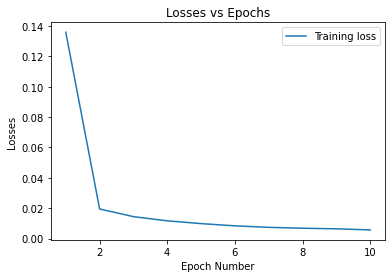

In [10]:
plt.plot(range(1,epochs+1),train_loss)
#plt.plot(range(1,epochs+1),val_loss)
plt.title('Losses vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Losses')
plt.legend(["Training loss"])
#plt.legend(["Training loss", "Validation loss"])

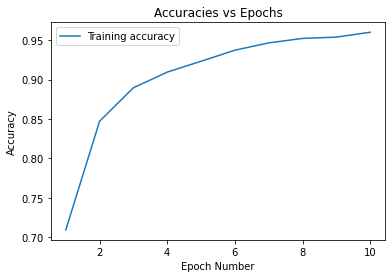

In [11]:
plt.plot(range(1,epochs+1),acc)
#plt.plot(range(1,epochs+1),val_acc)
plt.title('Accuracies vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(["Training accuracy"]) 
#plt.legend(["Training accuracy", "Validation accuracy"])

In [12]:
y_pred=cnn.predict(X_test)
'''as the softmax outputs probability of each class there is need for conversion from  probability to 0s and 1s
where the class corresponding to highest probability will be set to 1 and the rest to 0s.
y_pred is an array of probabilities where y_pred_binary is an array of 0s and 1s.'''
y_pred_binary=np.zeros(shape=y_pred.shape)
examples=y_pred.shape[0]
print(examples)
for i in range(examples):
    index=np.argmax(y_pred[i])
    y_pred_binary[i][index]=1


6120


In [13]:
data

array([[1.    , 0.    , 0.    , ..., 0.3509, 0.2171, 0.0742],
       [1.    , 0.    , 0.    , ..., 0.2756, 0.1917, 0.0747],
       [1.    , 0.    , 0.    , ..., 0.2847, 0.1762, 0.0945],
       ...,
       [0.    , 0.    , 0.    , ..., 0.2017, 0.0983, 0.0905],
       [0.    , 0.    , 0.    , ..., 0.1917, 0.0938, 0.0931],
       [0.    , 0.    , 0.    , ..., 0.1993, 0.1186, 0.1018]])

 # <table>ROC Curve</table>


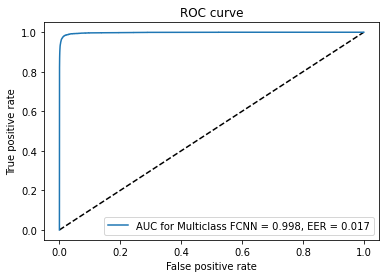

In [14]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def plotROC():
        
    predictions = cnn.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test.flatten(), predictions.flatten())
    eer = brentq(lambda x : 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC for {:5s} = {:.3f}, EER = {:.3f}'.format(
        "Multiclass FCNN", auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

plotROC()

# <table>**Data Visualization**</table>




In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn # statistical graphs
import matplotlib.pyplot as plt # data visualization / graphs
plt.style.use('seaborn-dark')


In [16]:
visual_data.iloc[:,:-1]

,subject,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,...,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return
0,s002,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,0.2212,0.1043,...,0.1120,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171
1,s002,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,0.1357,0.0449,...,0.0618,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917
2,s002,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,0.1542,0.0721,...,0.1566,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762
3,s002,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,0.2038,0.0998,...,0.0574,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387
4,s002,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,0.1589,0.0686,...,0.1545,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,s057,0.0884,0.0685,-0.0199,0.1095,0.1290,0.0195,0.0945,0.0757,-0.0188,...,0.1122,0.1219,0.1383,0.0164,0.0820,0.1329,0.0509,0.1005,0.2054,0.1049
20396,s057,0.0655,0.0630,-0.0025,0.0910,0.1148,0.0238,0.0916,0.0636,-0.0280,...,0.0201,0.1008,0.0512,-0.0496,0.1037,0.0868,-0.0169,0.1445,0.2206,0.0761
20397,s057,0.0939,0.1189,0.0250,0.1008,0.1122,0.0114,0.0721,0.0462,-0.0259,...,0.0505,0.0913,0.1169,0.0256,0.0689,0.1311,0.0622,0.1034,0.2017,0.0983
20398,s057,0.0923,0.1294,0.0371,0.0913,0.0990,0.0077,0.0992,0.0897,-0.0095,...,0.0383,0.0882,0.0821,-0.0061,0.0576,0.0697,0.0121,0.0979,0.1917,0.0938


# <table>Correlation Plot</table>

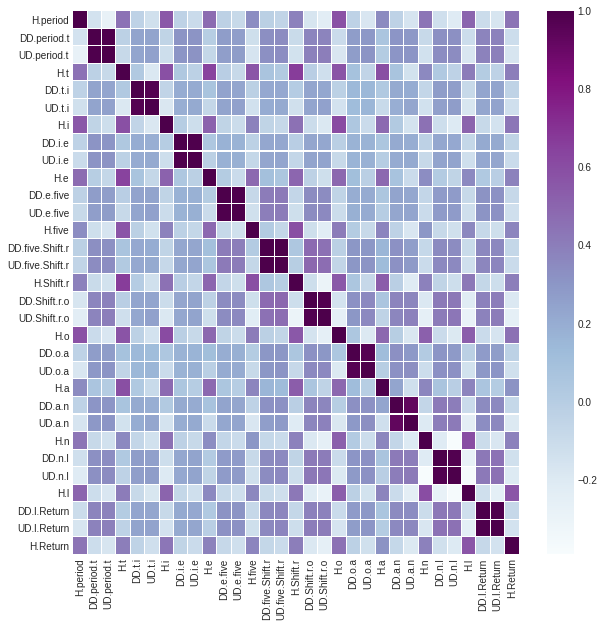

In [17]:
corrMatrix = visual_data[['H.period', 'DD.period.t',
       'UD.period.t', 'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e',
       'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r',
       'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o',
       'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l',
       'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(corrMatrix, linewidths=0.1, cmap="BuPu")
plt.show()

In [18]:
visual_data.columns
h_cols=['subject']
ud_cols=['subject']
dd_cols=['subject']
uu_cols=['subject']
for column in visual_data.columns:
    if 'H' in column:
        
        h_cols.append(str(column))
    if 'UD' in column:
        ud_cols.append(str(column))
    if 'DD' in column:
        dd_cols.append(str(column))
    if 'UU' in column:
        uu_cols.append(str(column))    
print(dd_cols)
print(uu_cols)
print(h_cols)
print(ud_cols)



['subject', 'DD.period.t', 'DD.t.i', 'DD.i.e', 'DD.e.five', 'DD.five.Shift.r', 'DD.Shift.r.o', 'DD.o.a', 'DD.a.n', 'DD.n.l', 'DD.l.Return']
['subject']
['subject', 'H.period', 'H.t', 'H.i', 'H.e', 'H.five', 'H.Shift.r', 'H.o', 'H.a', 'H.n', 'H.l', 'H.Return']
['subject', 'UD.period.t', 'UD.t.i', 'UD.i.e', 'UD.e.five', 'UD.five.Shift.r', 'UD.Shift.r.o', 'UD.o.a', 'UD.a.n', 'UD.n.l', 'UD.l.Return']


# <table>Average Inter subject variation</table>



# <table>1. H Plots</table>



<AxesSubplot:>

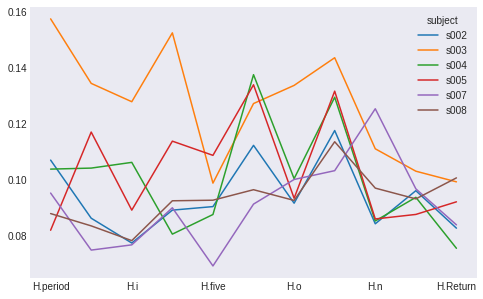

In [19]:
keyHoldLatency = visual_data[h_cols]
keyHoldLatency = keyHoldLatency.where((keyHoldLatency['subject']=='s002') | (keyHoldLatency['subject']=='s003') | (keyHoldLatency['subject']=='s004') | (keyHoldLatency['subject']=='s005') | (keyHoldLatency['subject']=='s007') | (keyHoldLatency['subject']=='s008'))
keyHoldLatency = keyHoldLatency.groupby('subject').agg('mean')
keyHoldLatency.T.plot(figsize=(8,5))

# <table>2. UD Plots</table>




<AxesSubplot:>

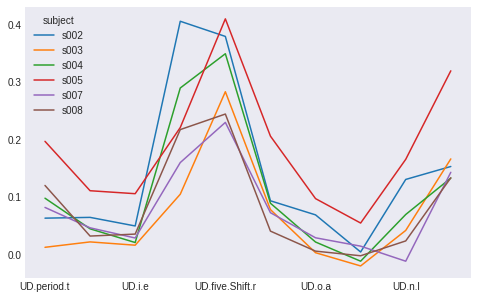

In [20]:
keyUDLatency = visual_data[ud_cols]
keyUDLatency = keyUDLatency.where((keyUDLatency['subject']=='s002') | (keyUDLatency['subject']=='s003') | (keyUDLatency['subject']=='s004') | (keyUDLatency['subject']=='s005') | (keyUDLatency['subject']=='s007') | (keyUDLatency['subject']=='s008'))
keyUDLatency = keyUDLatency.groupby('subject').agg('mean')
keyUDLatency.T.plot(figsize=(8,5))

# <table>3. DD Plots</table>





<AxesSubplot:>

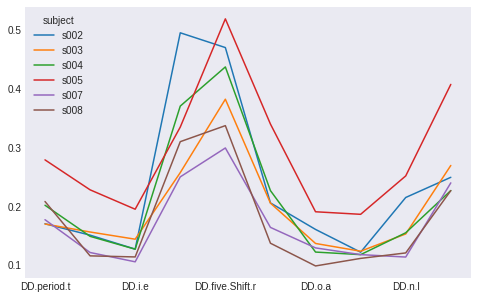

In [21]:
keyDDLatency = visual_data[dd_cols]
keyDDLatency = keyDDLatency.where((keyDDLatency['subject']=='s002') | (keyDDLatency['subject']=='s003') | (keyDDLatency['subject']=='s004') | (keyDDLatency['subject']=='s005') | (keyDDLatency['subject']=='s007') | (keyDDLatency['subject']=='s008'))
keyDDLatency = keyDDLatency.groupby('subject').agg('mean')
keyDDLatency.T.plot(figsize=(8,5))

# <table>Intrasubject variation</table>


# <table>1. H plot</table>


<AxesSubplot:>

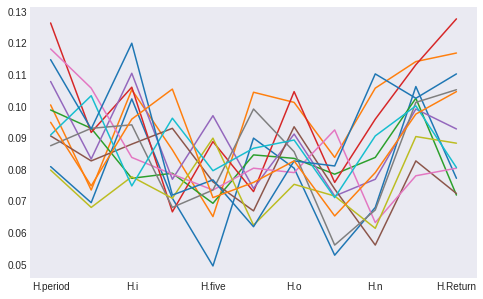

In [22]:
subKeyHoldLatency =visual_data.where((visual_data['subject']=='s021')).dropna().sample(n=12)
subKeyHoldLatency = subKeyHoldLatency[['subject','H.period','H.t','H.i', 'H.e','H.five','H.Shift.r','H.o','H.a','H.n','H.l','H.Return']]
subKeyHoldLatency = subKeyHoldLatency.set_index('subject')
subKeyHoldLatency.T.plot(figsize=(8,5), legend=False)

# <table>2. UD plot</table>


<AxesSubplot:>

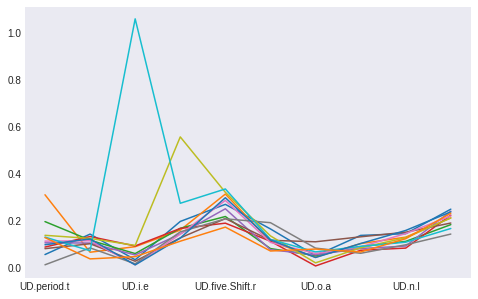

In [23]:
subKeyUDLatency = visual_data.where((visual_data['subject']=='s021')).dropna().sample(n=12)
subKeyUDLatency = subKeyUDLatency[['subject','UD.period.t','UD.t.i','UD.i.e','UD.e.five','UD.five.Shift.r','UD.Shift.r.o','UD.o.a','UD.a.n','UD.n.l','UD.l.Return']]
subKeyUDLatency = subKeyUDLatency.set_index('subject')
subKeyUDLatency.T.plot(figsize=(8,5), legend=False)

# <table>3. DD plot</table>




<AxesSubplot:>

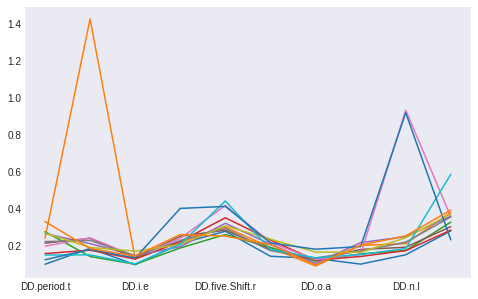

In [24]:
subKeyDDLatency = visual_data.where((visual_data['subject']=='s021')).dropna().sample(n=12)
subKeyDDLatency = subKeyDDLatency[['subject','DD.period.t','DD.t.i','DD.i.e','DD.e.five','DD.five.Shift.r', 'DD.Shift.r.o','DD.o.a','DD.a.n', 'DD.n.l','DD.l.Return']]
subKeyDDLatency = subKeyDDLatency.set_index('subject')
subKeyDDLatency.T.plot(figsize=(8,5), legend=False)